In [64]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
from scipy import misc
import matplotlib.pyplot as plt
from PIL import Image
from skimage import color
import os
import random
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.metrics import f1_score,accuracy_score
from sklearn import metrics
sns.set(style="white", palette="muted", color_codes=True)

In [60]:
from sklearn.externals import joblib
import xgboost as xgb

In [3]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression

In [4]:
from sklearn.metrics import auc, roc_curve, recall_score
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import make_pipeline
from scipy import interp

In [5]:
path = '/home/aremirata/thesis/DIARETB30/diaretdb0_v_1_1/resources/images/'
images_list = np.sort(os.listdir(path+'diaretdb0_fundus_images/'))
labels_files = np.sort(os.listdir(path+'diaretdb0_groundtruths/'))

In [6]:
image_arrays = []
image_name = []
for i in images_list:
    img = Image.open(path+'diaretdb0_fundus_images/'+i)
    img_rs = img.resize((256,256), Image.ANTIALIAS)
    a = np.asarray(img_rs)
    image_arrays.append(a)
    image_name.append(i)

In [7]:
image_arrays = np.asarray(image_arrays)

In [8]:
target_labels = []
for i in labels_files:
    text_file = open(path+'diaretdb0_groundtruths/'+i, "r")
    target_labels.append(np.asarray(text_file.read().lower().split()))

In [9]:
target_labels = np.asarray(target_labels)

In [10]:
np.unique(target_labels)

array(['hardexudates', 'hemorrhages', 'n/a', 'neovascularisation',
       'redsmalldots', 'softexudates'],
      dtype='<U18')

In [11]:
print(target_labels.shape)

(130, 5)


In [12]:
print(image_arrays.shape)

(130, 256, 256, 3)


In [13]:
target_labels_encoded = []
for i in target_labels:
    l = np.asarray([0 if j == 'n/a' else 1 for j in i])
    target_labels_encoded.append(l)

In [14]:
target_labels_encoded = np.asarray(target_labels_encoded)

In [15]:
target_labels_encoded.shape

(130, 5)

In [16]:
target_labels_modified = np.array([i/float(j) if j!=0 else i for i,j in zip(target_labels_encoded,np.sum(target_labels_encoded,axis=1))])

In [17]:
modified_classes = np.asarray([[1,0] if i==0 else [0,1] for i in np.sum(target_labels_encoded,axis=1)])

In [18]:
classes_unique = []
for i in range(target_labels.shape[1]):
    classes_unique = classes_unique + list(np.unique(target_labels[:,i])[np.unique(target_labels[:,i]) != 'n/a'])

In [19]:
classes_unique

['redsmalldots',
 'hemorrhages',
 'hardexudates',
 'softexudates',
 'neovascularisation']

In [20]:
modified_class_labels = ['normal','infected']

In [21]:
normal_retina_ids = np.argwhere(modified_classes[:,0]==1).reshape([-1])
affected_retina_ids = np.argwhere(modified_classes[:,0]==0).reshape([-1])

In [22]:
len(normal_retina_ids)

22

In [23]:
len(affected_retina_ids)

108

In [24]:
label_dict = {'normal':normal_retina_ids, 'affected': affected_retina_ids}

In [25]:
label_dict

{'affected': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109]),
 'normal': array([ 81,  94, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
        121, 122, 123, 124, 125, 126, 127, 128, 129])}

In [26]:
label_df = pd.DataFrame([label_dict]).transpose().reset_index().rename(columns={0:'indices','index':'label'})

In [27]:
label_df

,label,indices
0,affected,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,normal,"[81, 94, 110, 111, 112, 113, 114, 115, 116, 11..."


In [28]:
label_data = label_df.apply(lambda x: pd.Series(x['indices']), axis=1).stack().reset_index(level=1, drop=True)

In [29]:
label_data.name = 'index'

In [30]:
label_dataframe = label_df.drop('indices', axis=1).join(label_data)

In [31]:
label_dataframe.head()

,label,index
0,affected,0.0
0,affected,1.0
0,affected,2.0
0,affected,3.0
0,affected,4.0


In [32]:
targetmap = {'normal':0, 'affected':1}

In [33]:
label_dataframe['image_name'] = label_dataframe['index'].apply(lambda x: 'image'+str(int(x) + 1).zfill(3)+'.png')
label_dataframe['target'] = label_dataframe['label'].apply(lambda x: targetmap[x])
del label_dataframe['index']

In [34]:
label_dataframe.head()

,label,image_name,target
0,affected,image001.png,1
0,affected,image002.png,1
0,affected,image003.png,1
0,affected,image004.png,1
0,affected,image005.png,1


In [35]:
image_arrays_grayscale = []
for image in image_arrays:
    image_arrays_grayscale.append(color.rgb2gray(image))

In [36]:
image_arrays_grayscale[0].shape

(256, 256)

# Create a DataFrame to Store the Image Data Information

In [37]:
index = range(0, len(image_arrays_grayscale))
df_image = pd.DataFrame(index=index, columns=['image_name','grayscale_image'])
for i in range(len(image_arrays_grayscale)):
    df_image['image_name'][i] = image_name[i]
    df_image['grayscale_image'][i] = image_arrays_grayscale[i]

In [38]:
df_image.tail()

,image_name,grayscale_image
125,image126.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00..."
126,image127.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
127,image128.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
128,image129.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
129,image130.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0002827..."


In [39]:
df_image['image_flatten'] = df_image['grayscale_image'].apply(lambda x: x.ravel())

In [40]:
df_image.head()

,image_name,grayscale_image,image_flatten
0,image001.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,image002.png,"[[0.000833333333333, 0.0, 0.000833333333333, 0...","[0.000833333333333, 0.0, 0.000833333333333, 0...."
2,image003.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,image004.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,image005.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [41]:
dataset_df = pd.merge(df_image,label_dataframe,on='image_name',how='inner')

In [42]:
dataset_df.head()

,image_name,grayscale_image,image_flatten,label,target
0,image001.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",affected,1
1,image002.png,"[[0.000833333333333, 0.0, 0.000833333333333, 0...","[0.000833333333333, 0.0, 0.000833333333333, 0....",affected,1
2,image003.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",affected,1
3,image004.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",affected,1
4,image005.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",affected,1


In [43]:
len(dataset_df),len(df_image),len(label_dataframe)

(130, 130, 130)

# Apply NMF to the DataSet

In [44]:
data = np.stack(dataset_df['image_flatten'].as_matrix(),axis=0)

In [45]:
data.shape

(130, 65536)

In [46]:
sparsity_value =  np.count_nonzero(data)/np.prod(data.shape)

In [47]:
sparsity_value

0.89875769981971154

# Uncompressed BPP Implementation

In [47]:
%time W, H, n_iter, rel_error = nmf(data, n_components=100, max_iter=200, random_state=42)

CPU times: user 3h 55min 52s, sys: 9min 38s, total: 4h 5min 30s
Wall time: 34min 46s


/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


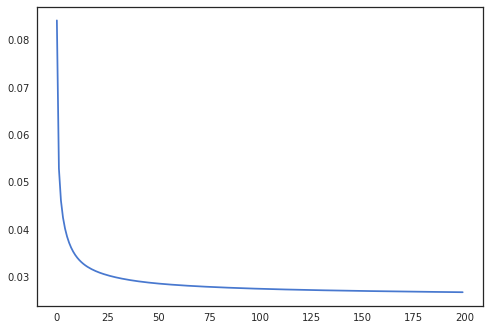

In [48]:
plt.plot(rel_error)

In [49]:
W = joblib.load('/home/aremirata/thesis/compressednmf/models/W_train.jl')
H = joblib.load('/home/aremirata/thesis/compressednmf/models/H_train.jl')
n_iters = joblib.load('/home/aremirata/thesis/compressednmf/models/n_iters_train.jl')
rel_errors = joblib.load('/home/aremirata/thesis/compressednmf/models/rel_errors_train.jl')

/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: The file '/home/aremirata/thesis/compressednmf/models/W_train.jl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  if __name__ == '__main__':
/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: The file '/home/aremirata/thesis/compressednmf/models/H_train.jl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  from ipykernel import kernelapp as app


In [50]:
X = W
y = np.stack(dataset_df['target'].as_matrix(),axis=0)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [56]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from collections import Counter

In [57]:
Counter(y_train)

Counter({0: 17, 1: 70})

In [58]:
def build_models(X, y, classifier=None, samplers=None):
    
    """
    Train model using the given training set and validate it through the validation set.
    If plot is true, the function plots the roc curve.
    
    Parameters
    ----------
    X: 2D-array
        Contains features from the dimension reduction methods used
        for training the dataset
    y: 
        The target variable we want to predict
    classifier: ist
        list of Scikit-learn model and its corresponding name
    samplers: str
        list of list of resampling models from imblearn module
    """
    
    best_model = None
    best_roc = -1
    
    cv = StratifiedKFold(n_splits=3)
    
    pipelines = [['{}-{}'.format(sampler[0], classifier[0]), make_pipeline(sampler[1], classifier[1])] for sampler in samplers]

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    for name, pipeline in pipelines:
        mean_tpr = 0.0
        mean_fpr = np.linspace(0, 1, 100)
        recalls = []
        
        for train, test in cv.split(X, y):
            
            pipeline.fit(X[train], y[train])
            pred_proba = pipeline.predict_proba(X[test])[:,1]
            fpr, tpr, thresholds = roc_curve(y[test], pred_proba)
            recalls.append(recall_score(y[test], pred_proba > 0.5))
            
            mean_tpr += interp(mean_fpr, fpr, tpr)
            mean_tpr[0] = 0.0
            roc_auc = auc(fpr, tpr)
            
            if roc_auc > best_roc:
                best_roc = roc_auc
                best_model = pipeline
                

        mean_tpr /= cv.get_n_splits(X, y)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        plt.plot(mean_fpr, mean_tpr, linestyle='--',
                 label='%s: (AUROC : %.3f), MeanTPR: %.3f)'% (name, mean_auc, np.array(recalls).mean()), lw=2)

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
             label='Luck')

    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')

    plt.legend(loc="lower right")

    plt.show()
    
    return best_model

/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


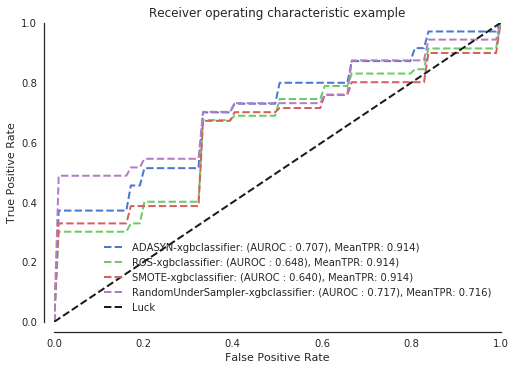

In [61]:
RANDOM_STATE = 42
sampl = [['ADASYN', ADASYN(random_state=RANDOM_STATE)],
    ['ROS', RandomOverSampler(random_state=RANDOM_STATE)],
    ['SMOTE', SMOTE(random_state=RANDOM_STATE)],
        ['RandomUnderSampler', RandomUnderSampler(random_state=RANDOM_STATE)]]
nmf_xgb = ['xgbclassifier', xgb.XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=3)]
nmfxgb_model = build_models(X_train, y_train, nmf_xgb, sampl)

/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


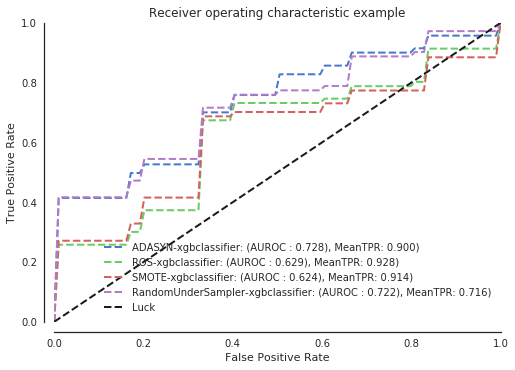

In [62]:
RANDOM_STATE = 42
sampl = [['ADASYN', ADASYN(random_state=RANDOM_STATE)],
    ['ROS', RandomOverSampler(random_state=RANDOM_STATE)],
    ['SMOTE', SMOTE(random_state=RANDOM_STATE)],
        ['RandomUnderSampler', RandomUnderSampler(random_state=RANDOM_STATE)]]
nmf_xgb = ['xgbclassifier', xgb.XGBClassifier()]
nmfxgb_model = build_models(X_train, y_train, nmf_xgb, sampl)

In [65]:
xgboost = nmfxgb_model
xgboost.fit(X_train, y_train)
y_pred_class = xgboost.predict(X_test)
y_pred_proba = xgboost.predict_proba(X_test)[:,1]
print("The accuracy score using {} classifier is {}".format('xgboost',metrics.accuracy_score(y_test, y_pred_class)))  
print("The roc auc score using {} classifier is {}".format('xgboost',metrics.roc_auc_score(y_test, y_pred_proba)))

The accuracy score using xgboost classifier is 0.6046511627906976
The roc auc score using xgboost classifier is 0.8315789473684211
